## 8. Ablakolt Fourier-transzformációs módszer, WFTMethod


Ezt az eljárást szimulált interferogramon mutatom be. Példaként generálok egyet:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysprint as ps

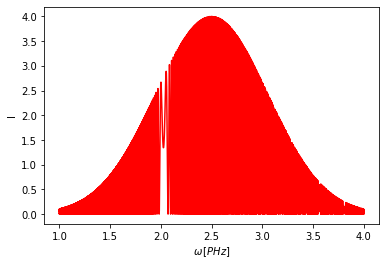

In [2]:
g = ps.Generator(1, 4, 2.5, delay=900, GDD=400, FOD=40000, pulse_width=3, resolution=0.05)
g.generate()

mywft = ps.WFTMethod(*g.data)
mywft.plot()

Ablakfüggvény sorozatot adok hozzá az interferogramhoz:

In [3]:
mywft.add_window_linspace(2.2, 3.1, 1000, fwhm=0.04, order=2)

**FONTOS!** 

Ha a fenti `add_window_linspace` lefutott, akkor az ablakfüggvény sorozat már hozzáadódott az interferogramhoz. Ha később megváltoztatnánk bármelyik paraméterét (pl. inkább más `fwhm`-ot szeretnénk beállítani), akkor az előző ablakfüggvények is megmaradak. Emiatt ajánlott a fenti cellát a következőképpen használni:

In [4]:
# az összes hozzáadott ablakfüggvény eltávolítása függetlenül attól, hogy korábban voltak-e
mywft.remove_all_windows()

# ezután adom hozzá az ablakfüggvény sorozatot
mywft.add_window_linspace(2.2, 3.1, 1000, fwhm=0.05, order=2)

Az aktuálisan hozzáadott ablakfüggvényeket a `WFTMethod.windows` paraméterrel érjük el, ami egy `dictionary`-t ad vissza, amelyben a *key* az ablakfüggvény központi helye, a hozzá tartozó *value* pedig maga az ablakfüggvény reprezentációja (`ps.core.method.wft.Window`).

In [5]:
len(mywft.windows)

1000

Ablakfüggvényt törölni a `remove_window_at(center)` függvénnyel lehetséges. Ennek az ablakfüggvény központi helyét kell megadni. Ha nincs olyan ablakfüggvény, akkor a hibaüzenetben segítséget nyújt: kiiírja a legközelebbi ablakfüggvényt.

In [6]:
mywft.remove_window_at(2.25)

ValueError: There is no window with center 2.25. Did you mean 2.24954954954955?

Mivel ez a módszer ún. [*embarrassingly parallel*](https://en.wikipedia.org/wiki/Embarrassingly_parallel) számítás, ezért lehetőség van több szálon futtatni a kiértékelést. 
Ehhez a [*Dask*](https://dask.org/) csomagnak telepítve kell lennie (Anaconda-ban alapértelmezetten benne van). Ezt a `parallel` argumentummal szabályozhatjuk. A többszálas futás általában 50-70% gyorsulást eredményez a single-core módhoz képest. A kiértékelést most `parallel=True` módon fogom futtatni:

In [7]:
mywft.calculate(reference_point=2.5, order=4, fastmath=False, parallel=True);

[########################################] | 100% Completed |  9.6s
Errors found: 0


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

A fenti `calculate` függvény ha már egyszer lefutott és megpróbáljuk újra lefuttatni más referencia ponttal vagy más illesztési renddel, akkor a gyorsítótárazás miatt azok már azonnal végrehajtódnak (csak az illesztést számolja újra).

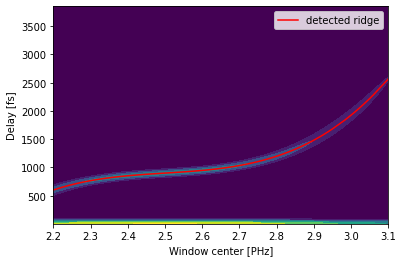

In [8]:
mywft.heatmap()

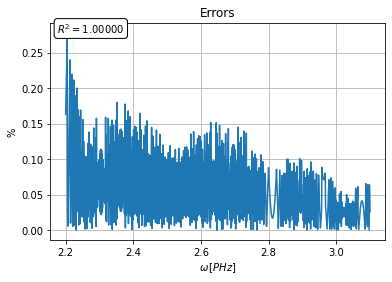

In [9]:
mywft.errorplot(percent=True)

Példa tetszőleges plotok készítésére:

c:\pyt\pysprint\pysprint\core\methods\wft.py:311: PySprintWarning: Image seems crowded, displaying only a subsample of the given windows.
  PySprintWarning
[ legend.py:1230 -   _parse_legend_args() ] No handles with labels found to put in legend.


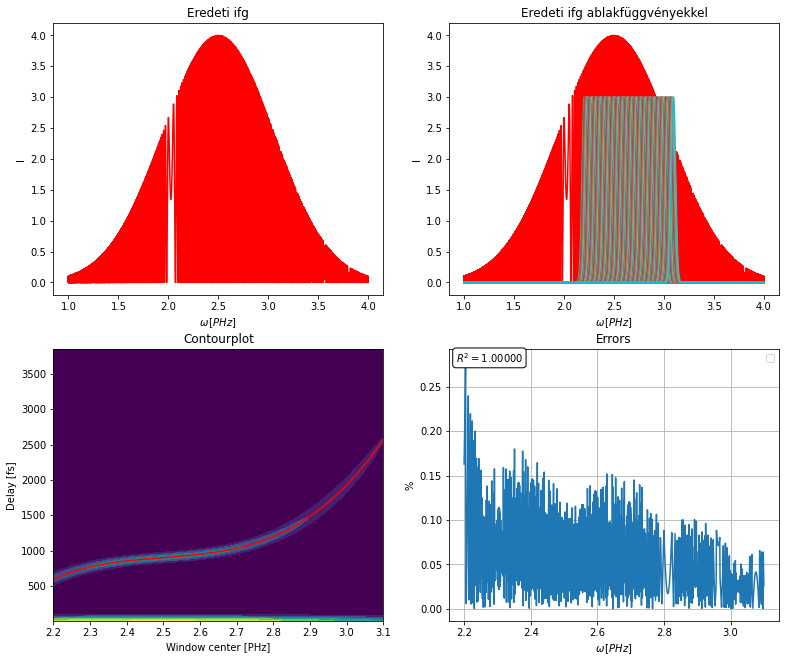

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))

mywft.plot(ax=ax1)
ax1.set(title="Eredeti ifg")

mywft.view_windows(ax=ax2, maxsize=200)
ax2.set(title="Eredeti ifg ablakfüggvényekkel")

mywft.heatmap(ax=ax3, include_ridge=True)
ax3.set(title="Contourplot");

mywft.errorplot(ax=ax4, percent=True)

Egy másik szimulált interferogram kiértékelését most `parallel=False` módon fogom elvégezni, és csak a `build_GD` függvényt használom, amivel a *GD* görbét kapom vissza (`ps.core.phase.Phase`).

In [11]:
f = ps.Generator(1, 4, 2.5, delay=1900, GDD=-600, TOD=4000, pulse_width=3, resolution=0.05)
f.generate()

mywft2 = ps.WFTMethod(*f.data)

In [12]:
mywft2.add_window_arange(1.5, 3.5, 0.01, std=0.04)

In [13]:
GD_gorbe = mywft2.build_GD()

Progress : [==============================] 100% (Errors: 0)

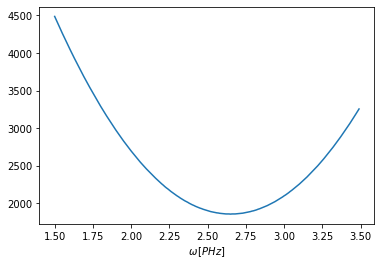

In [14]:
GD_gorbe.plot()

In [16]:
GD_gorbe.fit(reference_point=2.5, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

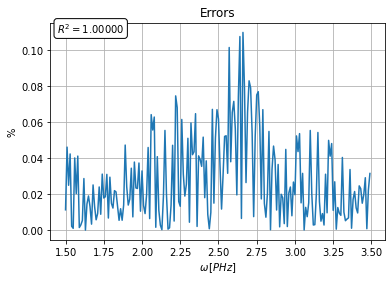

In [17]:
GD_gorbe.errorplot(percent=True)

A `fastmath` opciót itt nem adtam meg. Ez alapértelmezetten `True`, ilyenkor a `heatmap` nem hívható, mivel ekkor az ahhoz szükséges adatokat nem építi fel a program.

In [18]:
mywft2.heatmap()

ValueError: You need to recalculate with `fastmath=False` to plot the heatmap.

Néhány hiányosság: 

* A gerincvonalat a program automatikusan keresi meg, jelenleg még nincs lehetőség manuálisan állítani. Ez jól működik szimulált példákon, viszont rosszul is teljesíthet valós mérések esetén. Jelenleg ez a része a programnak fejlesztés alatt van (manuális állítás, különböző filterezése a detektált gerincvonalnak, pl. moving avarage validation.)


* Csak egyetlen egy gerincvonalat keres meg, így nem alkalmas pl. kettősen törő optikai szálak esetén, amikor mindkét polarizációs tengelye mentén terjedő módus egyidejűleg gerjesztve van. Szintén fejlesztés alatt van.
